# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
## IMPORTS
%matplotlib inline
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import glob
from IPython.display import display, Markdown, HTML
from IPython.display import Image as IImage
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from workspace_utils import active_session
import scipy
import numpy as np
import pandas as pd

---
## Step 0: Load The Data

In [2]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# For debugging prediction pipeline setup
X_org = np.copy(X_train)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
# image_shape = (training_w, trainig_h)

# TODO: How many unique classes/labels there are in the dataset.
n_classes, = np.unique(np.concatenate((y_train, y_valid, y_test))).shape

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", X_train.shape[1:])
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
%matplotlib inline

def hist_labels(y_train, y_test, y_valid, n_classes, bar_width = 0.25):
    """
    Plots the occurences of labels in the train, test and validation sets for comparison
    """
    training_counts = np.bincount(y_train)
    test_counts = np.bincount(y_test)
    valid_counts = np.bincount(y_valid)
    X = np.arange(n_classes)
    
    f, ax = plt.subplots(1,1, figsize=(20,10))
    ax.bar(X - bar_width, training_counts, width=bar_width, label='Training labels')
    ax.bar(X, test_counts, width=bar_width, label='Testing labels')
    ax.bar(X + bar_width, valid_counts, width=bar_width, label='Validation labels')
    ax.set_title('Traffic Sign Class Distribution per Data Set', fontsize=20)
    ax.set_xlabel('Class/Type', fontsize=16)
    ax.set_ylabel('Occurence', fontsize=16)
    ax.set(xticks=X, xlim=[-1, n_classes])
    ax.grid(zorder=0, axis="y", color='tab:gray', linestyle='-.', linewidth=0.5)
    ax.legend()
    
hist_labels(y_train, y_test, y_valid, n_classes)
plt.savefig("./explorations/class_distribution")
plt.close()

<h3>Generated by code above</h3>
<img src="./explorations/class_distribution.png">

In [5]:
%matplotlib inline
def sample_signs(X, y, csv_file="./signnames.csv", column="SignName", sample_size=10):
    """
    Creates a random sample of ten entries from each traffic sign class and saves each plot
    in a separate file.
    """
    data = pd.read_csv(csv_file)
    sign_names = data[column].tolist()

    for s, name in enumerate(sign_names):
        indices = np.where(y == s)
        for idxs in indices:
            f, ax = plt.subplots(1, sample_size, figsize=(10,10))
            f.tight_layout()
            idxs = np.random.choice(idxs, size=10, replace=False)
            samples = idxs[0:sample_size]
            for i, sample in enumerate(samples):
                ax[i].clear()
                if(i==9):
                    ax[i].set_title("Name: {} @ label idx {}".format(name, s), loc="right", fontsize=12)
                ax[i].imshow(X[sample])
                ax[i].set_xlabel("@{}".format(sample))
            
            plt.savefig("./explorations/sign_samples_{:0>3}".format(s), bbox_inches = 'tight')
            plt.close()

sample_signs(X_train, y_train)
plt.close()

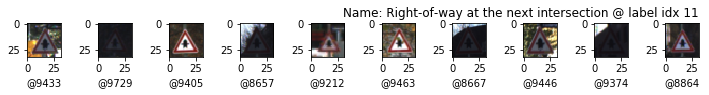

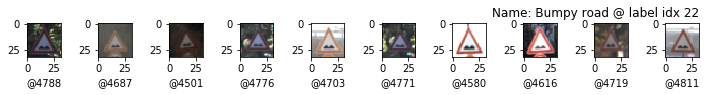

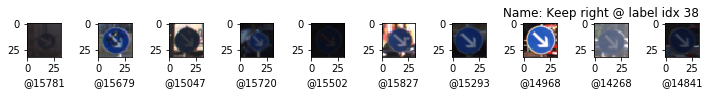

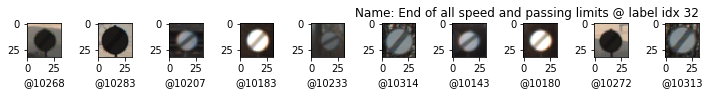

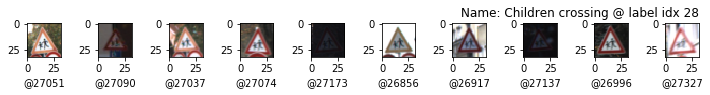

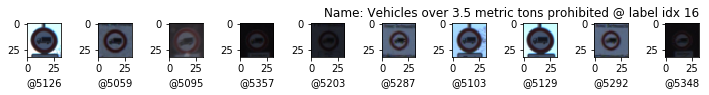

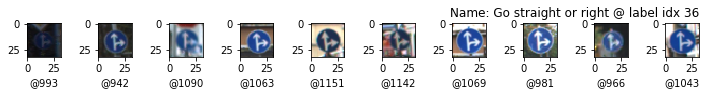

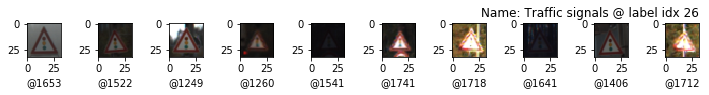

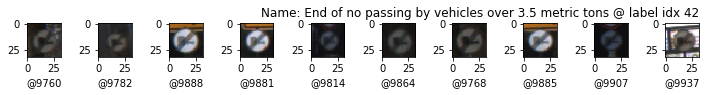

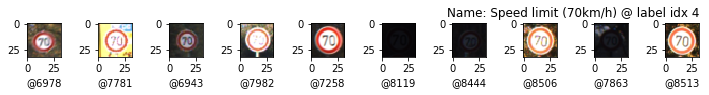

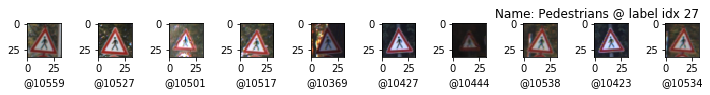

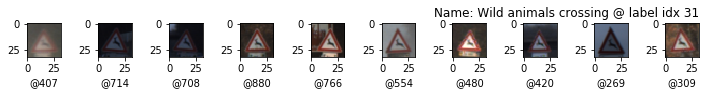

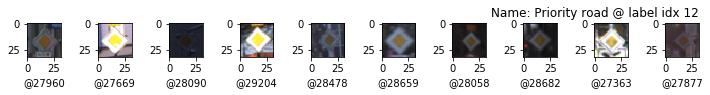

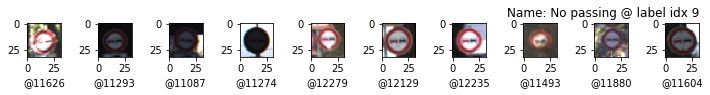

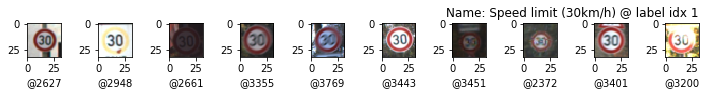

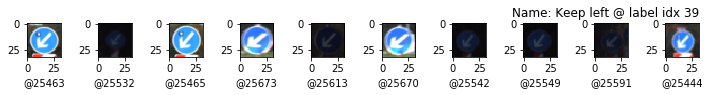

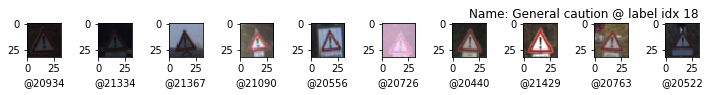

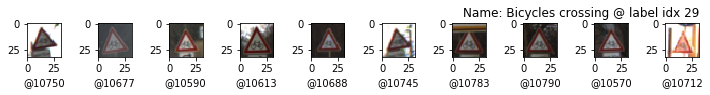

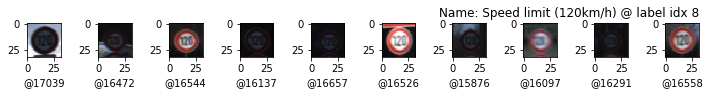

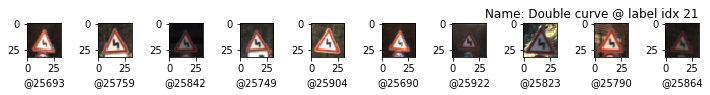

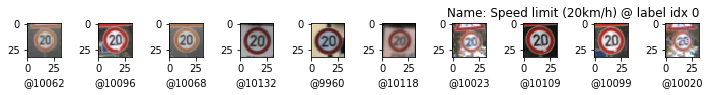

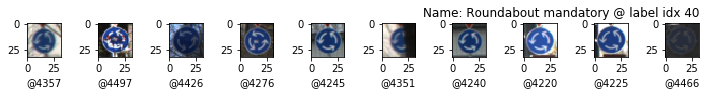

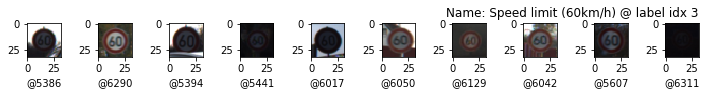

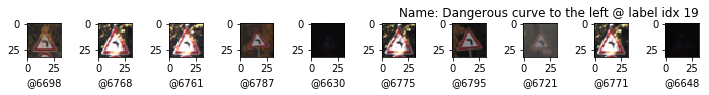

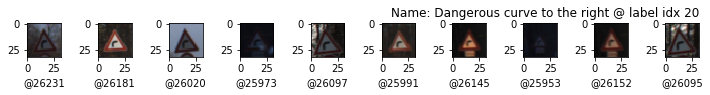

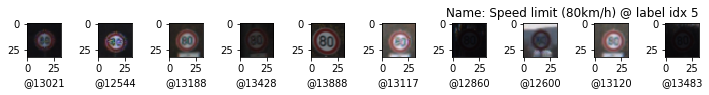

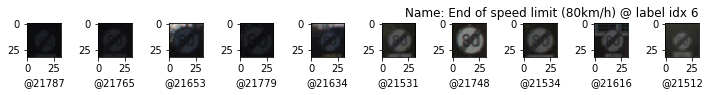

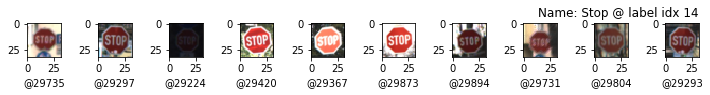

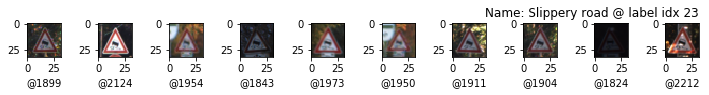

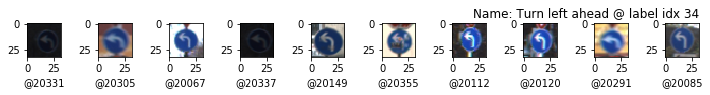

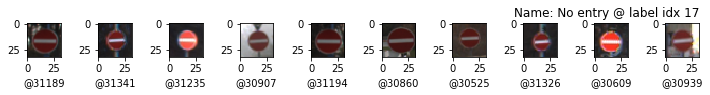

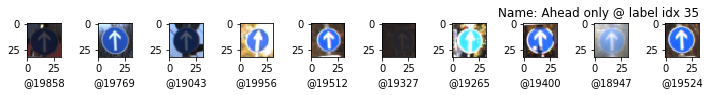

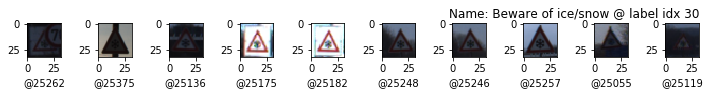

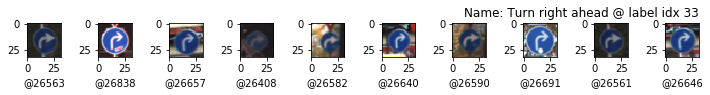

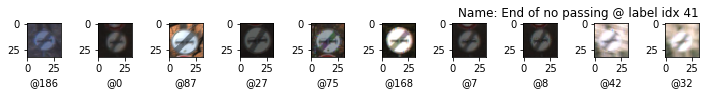

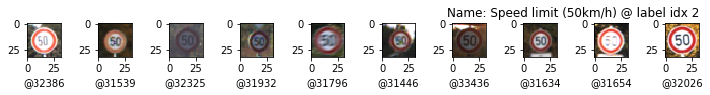

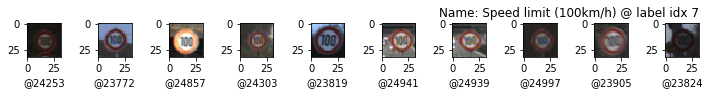

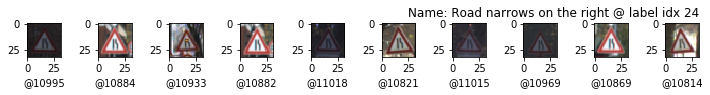

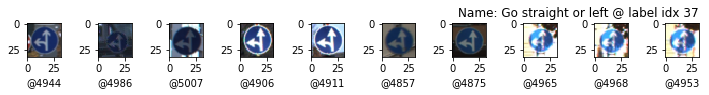

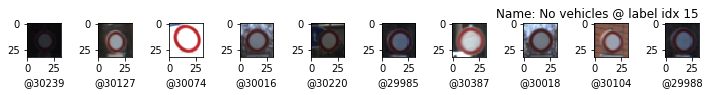

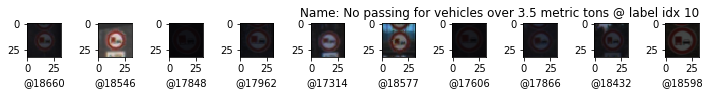

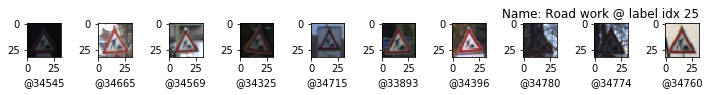

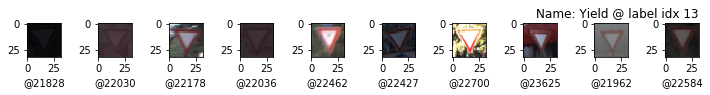

In [6]:
for file in glob.glob('./explorations/sign_samples_0*.png'):
    display(IImage(filename=file)) # IIMage org Image from Ipython library.

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [57]:
%matplotlib inline
def grayscale(x):
    """
    Simple grayscaling
    """
    return np.dot(x, [0.299 , 0.587, 0.114])

def normalize(x):
    """
    Normalize image pixels
    """
    return (x/128) - 1
    
def preprocess(features):
    """
    Preprocessing pipeline
    """
    features = grayscale(features)
    return normalize(features)

## Check pre-processing steps
before = X_train[27349]
after = preprocess(before)

f, ax = plt.subplots(1, 2, figsize=(5,5))
f.tight_layout()
ax[0].imshow(before)
ax[1].imshow(after, cmap="gray")
plt.savefig("./explorations/preprocessing.png")


ValueError: shapes (32,32,1) and (3,) not aligned: 1 (dim 2) != 3 (dim 0)

In [8]:
def augment(X, Y, r=10):
    # print('X', X.shape)
    A = [scipy.ndimage.rotate(image, r, reshape=False) for image in X]
    return np.append(X, A, axis=0), np.append(Y, Y)

In [9]:



X_train, y_train = augment(X_train, y_train, r=5)
X_train, y_train = augment(X_train, y_train, r=-5)

X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)

# last dimension was lost in previous step, add it back
X_train = np.expand_dims(X_train, 3)
X_valid = np.expand_dims(X_valid, 3)
X_test = np.expand_dims(X_test, 3)

### Model Architecture

In [62]:
## Helper functions to create layers

def conv_layer(X, D_in, D_out, F,S,P = 'VALID', mu = 0, sigma = 0.1):
    """
    Creates a Convolutional network layer
    
    X, D_in, D_out, F, S
    """
    # init weigths and bias
    W = tf.Variable(tf.truncated_normal(shape=(F, F, D_in, D_out), mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(D_out))

    # apply convolution and add bias to get net input
    net_input = tf.nn.conv2d(X, W, strides=[1, S, S, 1], padding=P) + b
    out = tf.nn.relu(net_input)
    # out = tf.nn.leaky_relu(net_input, alpha=0.02)
    return out

def full_con(X, inputs, outputs, mu = 0, sigma = 0.1):
    """
    Creates a Fully Connected network layer
    """
    W = tf.Variable(tf.truncated_normal(shape=(inputs, outputs), mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(outputs))

    net_input = tf.matmul(X, W) + b
    out = tf.nn.relu(net_input)
    
    return out

def pool(X, P='VALID'):
    """
    Creates a 2x2 Max Pool
    """
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=P)

In [66]:
## Defines the network graph

keep_prob = tf.placeholder(tf.float32) # Keep probabilty, forgot to make this adjustable for testing.

def graph(X):

    network_layers = []
    ## Convolutional Layer 1
    ## 
    ## INPUT: 32x32xC (C depends on preprocessing step, 1 for grayscale images)
    ## 
    ## Transfer function: Relu
    ## Pooled: yes
    conv = conv_layer(X, D_in=1, D_out=16, F=3, S=1)
    print('Convolution layer 1 OUTPUT: ', conv.shape)
    
    network_layers.append(conv)
    out = pool(conv)
    print('Pool layer 1 OUTPUT: ', out.shape)

    
    ## Convolutional Layer 2
    ##
    ## INPUT: 15x15x16
    ## Transfer function: Relu
    ## Pooled: yes
    out = conv_layer(out, D_in=16, D_out=64, F=3, S=1)
    print('Convolution layer  2 OUTPUT: ', out.shape)
    out = pool(out)
    print('Pool layer 2 OUTPUT: ', out.shape)


    ## Convolutional Layer 3 
    ##
    ## INPUT: 6x6x64
    ## Transfer function: Relu
    ## Pooled: yes
    out = conv_layer(out, 64, 256, 3, 1)
    print('Convolution layer  3 OUTPUT: ', out.shape)
    out = pool(out)
    print('Pool layer 3 OUTPUT: ', out.shape)


    ## FLATTEN
    ##
    ## INPUT: 2x2x256
    ##
    ## Reshaping inputs to prepare for scaling towards required ouput size of n classes 
    out = flatten(out)
    print('Flatten layer OUTPUT: ', out.shape)


    ## FULLY CONNECTED Layer 1
    ##
    ## Transfer function: Relu
    out = full_con(out, 1024, 120)
    print('Fully connected layer 1 OUTPUT: ', out.shape)
    
    out = tf.nn.dropout(out, keep_prob)
    
    ## FULLY CONNECTED OUTPUT
    ##
    ## Transfer function: Relu
    ## OUTPUT DIMENSIONS: 44 * 1 (Classes/Types of Traffic Sign)
    out = full_con(out, 120, 43)

    print('Output layer: ', out.shape)
    return out, network_layers

In [67]:
## Pipeline Setting

## 1. EPOCH 46 no augmentation.
## Accuracy = 0.926
## 2. EPOCH 46 double augmentation 
## Accuracy = 0.971
# RATE = 0.0005

## 3. 
## Accuracy = 
RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 1024
MODEL_FILE = './models/traffic-sign-model3.ckpt'


In [68]:
## Pipeline

## SETUP TRAINING BATCH VARIABLES
x_batch = tf.placeholder(tf.float32, (None, 32, 32, 1)) # batch_size unknown, width, height, depth (color channels)
y_batch = tf.placeholder(tf.int32, (None)) # batch_size unknown

## SETUP ONE HOT ENCODER
one_hot_encoding = tf.one_hot(y_batch, 43)

## Instantiate network graph
logits, network_layers = graph(x_batch)

# Define loss and optimizer functions
cross = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_encoding)
loss = tf.reduce_mean(cross)
optimizer = tf.train.AdamOptimizer(learning_rate=RATE) # Default rate = 0.001 according to docs
training = optimizer.minimize(loss)

Convolution layer 1 OUTPUT:  (?, 30, 30, 16)
Pool layer 1 OUTPUT:  (?, 15, 15, 16)
Convolution layer  2 OUTPUT:  (?, 13, 13, 64)
Pool layer 2 OUTPUT:  (?, 6, 6, 64)
Convolution layer  3 OUTPUT:  (?, 4, 4, 256)
Pool layer 3 OUTPUT:  (?, 2, 2, 256)
Flatten layer OUTPUT:  (?, 1024)
Fully connected layer 1 OUTPUT:  (?, 120)
Output layer:  (?, 43)


In [69]:
### EVALUATION
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_encoding, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples,w,h,d = X_data.shape
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x_batch: batch_x, y_batch: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [72]:
### Calculate and report the accuracy on the training and validation set.
with active_session():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples, x,y,d = X_train.shape

        print("Training...")
        print("Examples", num_examples)
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)

            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training, feed_dict={x_batch: batch_x, y_batch: batch_y, keep_prob:0.5})

            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ".format(i+1))
            print("Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, MODEL_FILE)
        print("Model saved")

Training...
Examples 139196
EPOCH 1 
Accuracy = 0.734

EPOCH 2 
Accuracy = 0.861

EPOCH 3 
Accuracy = 0.903

EPOCH 4 
Accuracy = 0.924

EPOCH 5 
Accuracy = 0.927

EPOCH 6 
Accuracy = 0.949

EPOCH 7 
Accuracy = 0.943

EPOCH 8 
Accuracy = 0.951

EPOCH 9 
Accuracy = 0.947

EPOCH 10 
Accuracy = 0.958

EPOCH 11 
Accuracy = 0.958

EPOCH 12 
Accuracy = 0.959

EPOCH 13 
Accuracy = 0.962

EPOCH 14 
Accuracy = 0.962

EPOCH 15 
Accuracy = 0.959

EPOCH 16 
Accuracy = 0.964

EPOCH 17 
Accuracy = 0.965

EPOCH 18 
Accuracy = 0.961

EPOCH 19 
Accuracy = 0.964

EPOCH 20 
Accuracy = 0.963

EPOCH 21 
Accuracy = 0.968

EPOCH 22 
Accuracy = 0.969

EPOCH 23 
Accuracy = 0.966

EPOCH 24 
Accuracy = 0.970

EPOCH 25 
Accuracy = 0.965

EPOCH 26 
Accuracy = 0.970

EPOCH 27 
Accuracy = 0.961

EPOCH 28 
Accuracy = 0.970

EPOCH 29 
Accuracy = 0.966

EPOCH 30 
Accuracy = 0.967

EPOCH 31 
Accuracy = 0.971

EPOCH 32 
Accuracy = 0.973

EPOCH 33 
Accuracy = 0.972

EPOCH 34 
Accuracy = 0.968

EPOCH 35 
Accuracy = 0.974

E

In [73]:
with active_session():
    with tf.Session() as session:
        saver.restore(session, MODEL_FILE)

        test_accuracy = evaluate(X_train, y_train)
        print('Training Accuracy: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Training Accuracy: 0.9999712635420558


In [74]:
with active_session():
    with tf.Session() as session:
        saver.restore(session, MODEL_FILE)

        test_accuracy = evaluate(X_valid, y_valid)
        print('Validation Accuracy: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Validation Accuracy: 0.9755102030003693


In [76]:
### Test set accuracy.
with active_session():
    with tf.Session() as session:
        saver.restore(session, MODEL_FILE)
        
        test_accuracy = evaluate(X_test, y_test)

        print('Test Accuracy: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Test Accuracy: 0.9600158362094127


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [77]:

data = pd.read_csv('./signnames.csv')
sign_names = data['SignName'].tolist()

def new_images_plot(images, labels):
    f, ax = plt.subplots(1,5, figsize=(10,10))
    f.tight_layout()
    for i, img in enumerate(images):
        ax[i].set_title(sign_names[labels[i]])
        ax[i].imshow(img)

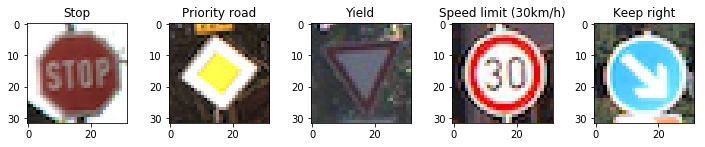

In [78]:
# These images are from the same dataset as the original sets but downloaded and random chosen.
# I had problems with png/jpeg encoding (assumption) and needed to check my
# picture editing/pipeline mistakes to check if these would give close to 100% on known pictures.
files_gtsrb = sorted(glob.glob('./web/gtsrb*.jpeg'))
images_gtsrb = [np.array(Image.open(file)) for file in files_gtsrb]
labels_gtsrb = [14,12,13,1,38] # ./web/gtsrb*.jpeg

new_images_plot(images_gtsrb, labels_gtsrb)

images_prediction, labels_shutter = augment(images_gtsrb, labels_gtsrb, r=5)
images_prediction = preprocess(images_prediction)
images_prediction = np.expand_dims(images_prediction, 3)

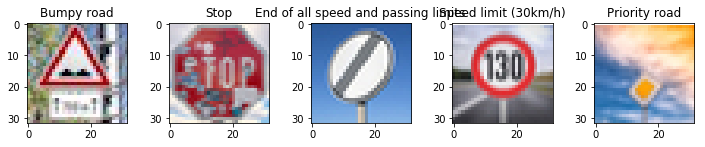

In [79]:
# These 5 images are obtained from Shutterstock and manually edited to fit.
# It includes two pictures that I expect not to be predicted correctly. I added these to see the prediction.
files_shutter = sorted(glob.glob('./web/download*.jpeg'))
images_shutter = [np.array(Image.open(file)) for file in files_shutter]
# labels_shutter = [22,14,1,32,12] # ./web/download*.jpeg
labels_shutter = [22,14,32,1,12]
new_images_plot(images_shutter, labels_shutter)

images_prediction_final, labels_shutter = augment(images_shutter, labels_shutter, r=5)
images_prediction_final = preprocess(images_prediction_final)
images_prediction_final = np.expand_dims(images_prediction_final, 3)

### Predict the Sign Type for Each Image

In [80]:
# Prediction for images out of the dame dataset
softmax = tf.nn.softmax(logits)

with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    result = session.run(softmax, feed_dict={x_batch: images_prediction[0:5,:,:,:], keep_prob:1}) 
    result = np.argmax(result, axis=1)
    print('Prediction: {}'.format([sign_names[idx] for idx in result]))


INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Prediction: ['Stop', 'Priority road', 'Yield', 'Speed limit (30km/h)', 'Keep right']


In [81]:
# Prediction for images from web
softmax = tf.nn.softmax(logits)

with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    result = session.run(softmax, feed_dict={x_batch: images_prediction_final[0:5,:,:,:], keep_prob:1}) 
    result = np.argmax(result, axis=1)
    print('Prediction: {}'.format([sign_names[idx] for idx in result]))


INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Prediction: ['No passing', 'Stop', 'Road work', 'Speed limit (50km/h)', 'Yield']


### Analyze Performance

In [82]:

with tf.Session() as session:
    saver.restore(session, MODEL_FILE)

    test_accuracy = session.run(accuracy_operation, feed_dict={x_batch: images_prediction_final, y_batch: labels_shutter, keep_prob:1})

    print('Test Accuracy: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Test Accuracy: 0.20000000298023224


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [83]:
softmax = tf.nn.softmax(logits)

with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    result = session.run(softmax, feed_dict={x_batch: images_prediction_final[0:5,:,:,:], keep_prob:1}) 
    top_5 = session.run(tf.nn.top_k(tf.constant(result), k=5))
    
    
    probabilities, labels = top_5[0], top_5[1]
    
    
    row = "| {} | {} | {} |"
    
    for i, label in enumerate(labels_shutter[0:5]):
        print(sign_names[label], label)
        print("| Probability | Prediction| Label |")
        print("|:-----------:|:---------:|:------| ")
        for j, probability in enumerate(probabilities[i]):
             print(row.format(int(probability * 1000) / 1000, sign_names[labels[i][j]], labels[i][j]))
    
#     
# print('Prediction: {}'.format())


INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt
Bumpy road 22
| Probability | Prediction| Label |
|:-----------:|:---------:|:------| 
| 0.99 | No passing | 9 |
| 0.009 | Slippery road | 23 |
| 0.0 | Speed limit (60km/h) | 3 |
| 0.0 | Bumpy road | 22 |
| 0.0 | Bicycles crossing | 29 |
Stop 14
| Probability | Prediction| Label |
|:-----------:|:---------:|:------| 
| 0.726 | Stop | 14 |
| 0.271 | General caution | 18 |
| 0.0 | Road work | 25 |
| 0.0 | Priority road | 12 |
| 0.0 | Keep left | 39 |
End of all speed and passing limits 32
| Probability | Prediction| Label |
|:-----------:|:---------:|:------| 
| 0.999 | Road work | 25 |
| 0.0 | Yield | 13 |
| 0.0 | Traffic signals | 26 |
| 0.0 | Keep left | 39 |
| 0.0 | Bicycles crossing | 29 |
Speed limit (30km/h) 1
| Probability | Prediction| Label |
|:-----------:|:---------:|:------| 
| 0.999 | Speed limit (50km/h) | 2 |
| 0.0 | Speed limit (120km/h) | 8 |
| 0.0 | Stop | 14 |
| 0.0 | Keep right | 38 |
| 0.0 |

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt


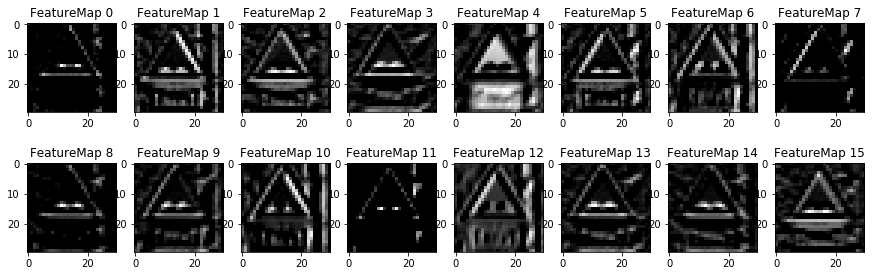

In [87]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=session,feed_dict={x_batch : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    outputFeatureMap(np.expand_dims(images_prediction_final[0], 0), network_layers[0])

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt


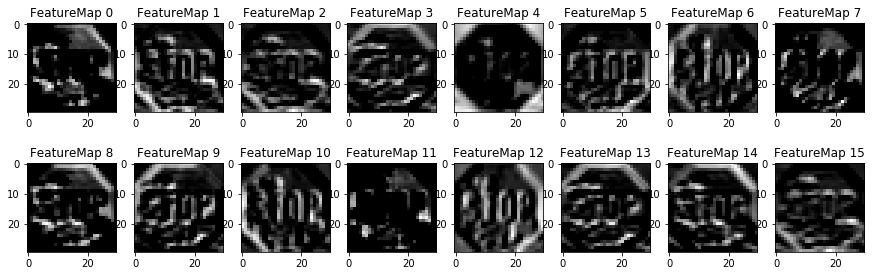

In [88]:
with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    outputFeatureMap(np.expand_dims(images_prediction_final[1], 0), network_layers[0])

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt


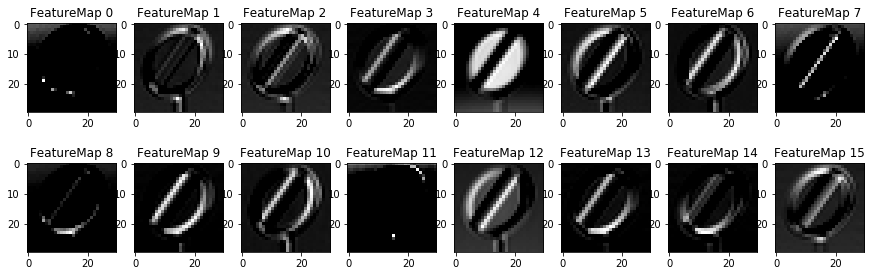

In [90]:
with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    outputFeatureMap(np.expand_dims(images_prediction_final[2], 0), network_layers[0])

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt


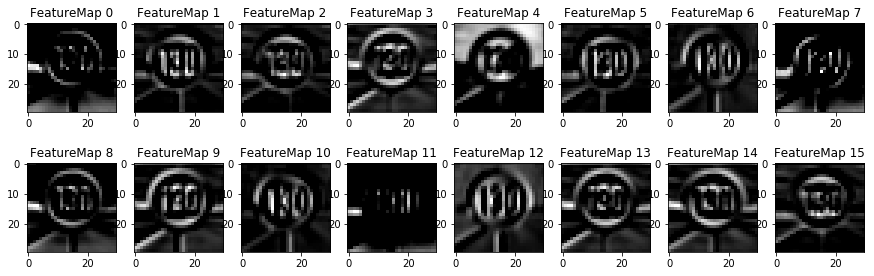

In [91]:
with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    outputFeatureMap(np.expand_dims(images_prediction_final[3], 0), network_layers[0])

INFO:tensorflow:Restoring parameters from ./models/traffic-sign-model3.ckpt


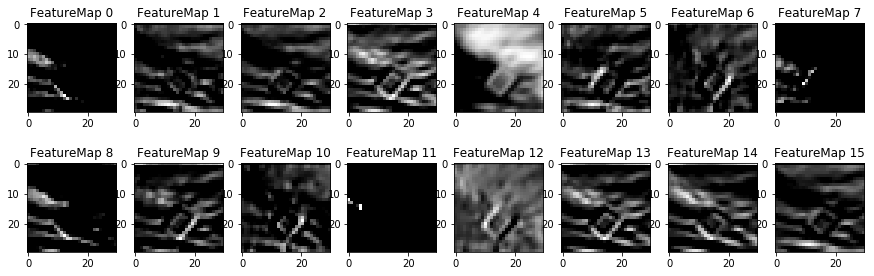

In [92]:
with tf.Session() as session:
    saver.restore(session, MODEL_FILE)
    outputFeatureMap(np.expand_dims(images_prediction_final[4], 0), network_layers[0])